In [143]:

import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import joblib
warnings.filterwarnings('ignore')

In [144]:
path = "https://frenzy86.s3.eu-west-2.amazonaws.com/python/data/realcase/dataset_costi.xlsx"
df = pd.read_excel(path)
df.head()

,index,Ragione sociale,costi anno 2020,var1,var2,var3,var4,var5,var6,var7,...,Numero CCIAA,Codice fiscale,Partita IVA,var153,var154,var155,var156,var157,var158,var159
0,101,company101,144205134,147823139,148193655,0,0,0,51344312,61401789,...,20680,256,10696,84978,318158,318158,25290616,24108358,24535319,Produ
1,102,company102,140165127,147562322,163251010,0,0,0,1037776,1391301,...,20681,257,10697,1583,1583,1588,14133394,10404117,12898505,Produ
2,103,company103,145190000,147562000,142652000,0,0,0,737000,707000,...,20682,258,10698,1801000,1761000,1171000,31861000,22494000,24687000,Produ
3,104,company104,112760368,147067625,140160124,0,0,0,39316,5715,...,20683,259,10699,890646,0,0,1000000,0,1188439,Produ
4,105,company105,171980718,145273739,127413305,0,0,0,6571906,3613836,...,20684,260,10700,0,0,0,27325115,24037285,24492237,Produ


In [255]:
ndf = df.nunique()
ndf[ndf < 100]

var24                               2
var25                               2
var26                               4
var138                             36
var139                             31
var144                              1
var145                              1
var146                              1
Indirizzo sede legale - Regione    20
var159                              1
dtype: int64

In [145]:
df['costi anno 2020'].value_counts()

0          39
251293      2
919429      2
245800      2
316004      2
           ..
3693503     1
4382316     1
3723472     1
3190492     1
74478       1
Name: costi anno 2020, Length: 7871, dtype: int64

In [146]:
# REMOVE ROWS WITH VALUE 0 IN THE TARGET
df = df[df['costi anno 2020'] != 0]

In [147]:
data_types = df.dtypes
non_unique_counts = df.nunique()
filtered_data = non_unique_counts[non_unique_counts < 1000]
feature_info = pd.DataFrame({'Data Type': data_types.loc[filtered_data.index], 'Non-Unique Count': filtered_data.values})
print(feature_info)


                                Data Type  Non-Unique Count
var3                                int64               256
var4                               object               256
var5                               object               247
var21                               int64               572
var22                               int64               571
var23                               int64               518
var24                              object                 2
var25                              object                 2
var26                              object                 4
var36                              object               336
var37                              object               359
var38                              object               355
var42                               int64               906
var43                              object               886
var44                              object               835
var87                               int6

In [342]:
correlation_matrix = df.corr()
correlation_with_target = correlation_matrix['costi anno 2020']
sorted_correlation = correlation_with_target.abs().sort_values(ascending=False).nlargest(10)
top_features = sorted_correlation.index.tolist()

In [343]:
len(sorted_correlation[sorted_correlation > 0.3])

10

In [344]:
X = df[top_features].drop(columns='costi anno 2020')
y = df['costi anno 2020']
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

In [345]:
# pca = PCA(n_components=5)
# X_pca = pca.fit_transform(X_imputed)

In [346]:
X_train, X_val, y_train, y_val = train_test_split(X_imputed, y, test_size=0.3, random_state=42)

# Further split the validation set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)


In [347]:
model = RandomForestRegressor(max_depth=20, max_leaf_nodes=100)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, max_leaf_nodes=100)

In [392]:
feat_list = []
imp_list = []
importance = model.feature_importances_
feature_importance = dict(zip(X.columns, importance))
sorted_feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_feature_importance:
    feat_list.append(feature)
    imp_list.append(importance)
    print(f"{feature}: {importance}")

var93: 0.997532687912244
var99: 0.0010659992914538283
var84: 0.00030286275988315286
var30: 0.00023222775802658247
var86: 0.00022407686557112115
var35: 0.00021883883915783652
var33: 0.00017907728787774717
var34: 0.00014873351915922176
var102: 9.549576662649625e-05


Text(0.5, 1.0, 'Feature Importance')

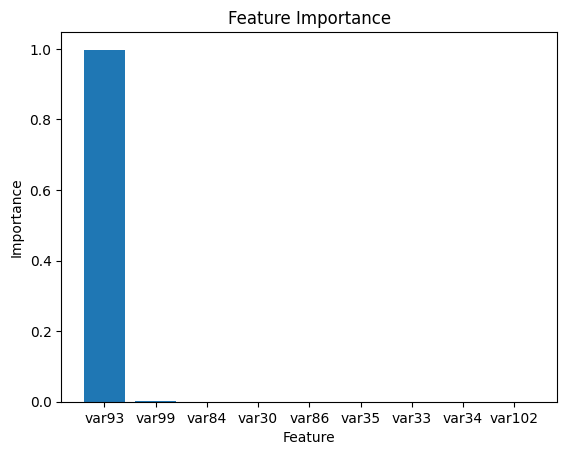

In [395]:
plt.bar(feat_list, imp_list)

# Set the labels and title
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')

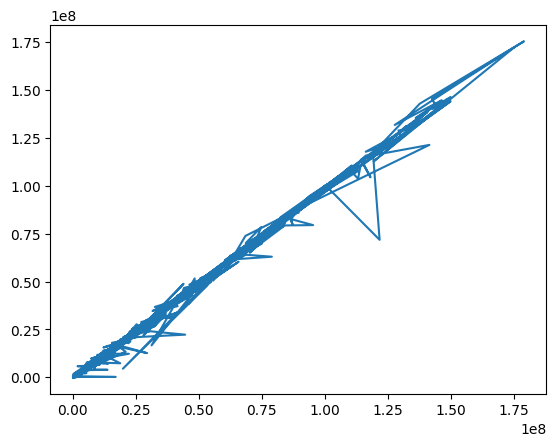

In [349]:
plt.plot(df['var93'], df['costi anno 2020'])

In [350]:
y_pred = model.predict(X_val)

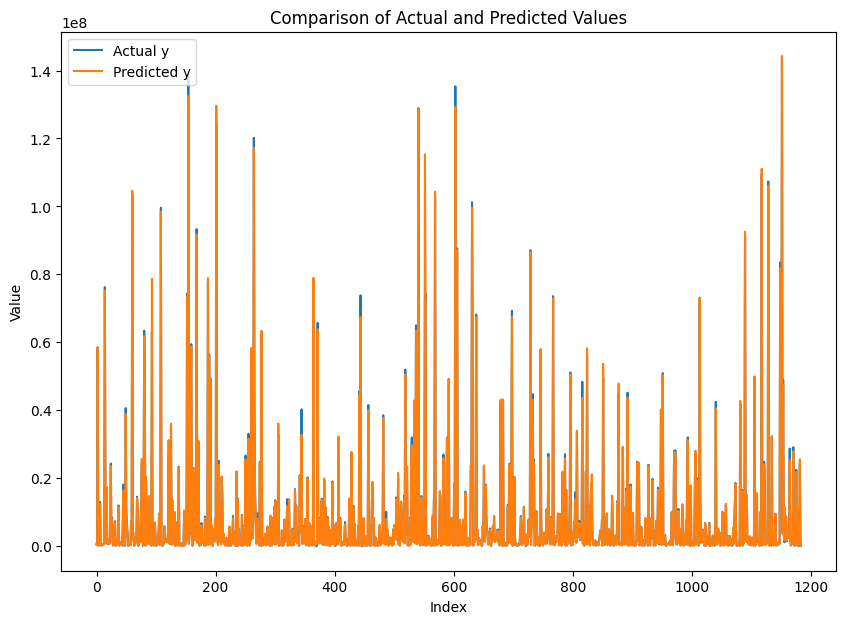

In [351]:
length = y_pred.shape[0]
x = np.linspace(0, length, length)

plt.figure(figsize=(10, 7))
plt.plot(x, y_val, label='Actual y')
plt.plot(x, y_pred, label="Predicted y")
plt.legend(loc='upper left')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Comparison of Actual and Predicted Values');

In [352]:
from sklearn.metrics import r2_score, mean_squared_error

mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared Score: {r2}")

Mean Squared Error: 2262211344836.2666
Root Mean Squared Error: 1504064.9403653643
R-squared Score: 0.9925727485573987


In [353]:
max_depths = [estimator.tree_.max_depth for estimator in model.estimators_]
max_depth = max(max_depths)
max_depth

12

In [354]:
y_train_pred = model.predict(X_train)

In [355]:
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)

In [356]:
print("Training Set Performance:")
print(f"Root Mean Squared Error: {rmse_train}")
print(f"R-squared Score: {r2_train}")
print("\nTest Set Performance:")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared Score: {r2}")

Training Set Performance:
Root Mean Squared Error: 476745.791635248
R-squared Score: 0.9991492865387928

Test Set Performance:
Root Mean Squared Error: 1504064.9403653643
R-squared Score: 0.9925727485573987


In [357]:
output = model.predict(X_test)

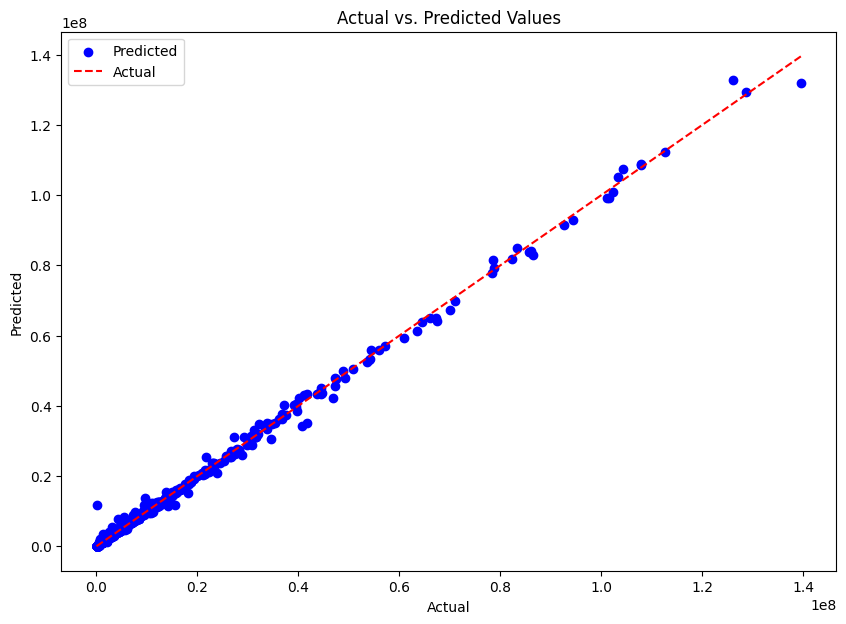

In [358]:
plt.figure(figsize=(10, 7))
plt.scatter(y_test, output, c='b', label='Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

In [359]:
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': output})
comparison['Predicted'] = comparison['Predicted'].apply(lambda x: '{:.2f}'.format(x))
print(comparison)

        Actual    Predicted
6115    379873    437781.83
6887    216702    214595.79
1163  10853888  12368275.94
1477  10728647   9521268.41
4675   2985109   2796548.32
...        ...          ...
5062    744846    802405.99
3196   2537594   2576795.31
6142    336357    232957.53
3337   2205290   2086369.74
2750   3182235   3104013.82

[1183 rows x 2 columns]


In [360]:
comparison['Predicted'] = comparison['Predicted'].astype(float).astype(int)

In [361]:
comparison['error'] = abs(comparison['Predicted'] - comparison['Actual'])

In [316]:
comparison

,Actual,Predicted,error
6115,379873,391458,11585
6887,216702,241942,25240
1163,10853888,11897360,1043472
1477,10728647,9645176,1083471
4675,2985109,2939033,46076
...,...,...,...
5062,744846,744239,607
3196,2537594,2510167,27427
6142,336357,334683,1674
3337,2205290,2126692,78598


In [163]:
# joblib.dump(model, filename="RFR_model1.pkl")